# Youjung Park
## Machine Learning Midterm
### 05/24/2023

In [92]:
import json

# Retrieve credentials to connect to mongodb
with open('mongo.credentials.json') as f:
    data = json.load(f)
    connection_string = data['mongodb']

In [93]:
import pymongo
import certifi

# Connect to the server and retrieve the database in mongodb
client = pymongo.MongoClient(connection_string, tlsCAFile=certifi.where())

# Open the database in mongodb
db_da320 = client.DA320

# Open the collection in mongodb
collections = db_da320.list_collection_names()

# Print mongodb info and collections to check if it has connected correctly
print(f"Using MongoDB version {client.server_info()['version']}.")
print(f"This database has the collections {collections}")

Using MongoDB version 6.0.6.
This database has the collections ['metacritic_movie', 'imdb_Superhero', 'IMDB_Pipeline_View', 'Metacritic_Pipeline_View']


In [94]:
import pandas as pd
import datetime
import re

# Read collection name "IMDB_Pipeline_View" and "Metacritic_Pipeline_View"
collection_imdb = db_da320.imdb_Superhero
collection_metacritic = db_da320.metacritic_movie

# Retrieve 2019 movie data from each collection
cursor_imdb = collection_imdb.find({"release_date" : re.compile("2019")})
cursor_metacritic = collection_metacritic.find({"release_date" : re.compile("2019")})

# Convert the data into a Pandas Dataframe
imdb = pd.DataFrame(cursor_imdb)
metacritic = pd.DataFrame(cursor_metacritic)

# Print the data to verify the written code
print(f"{len(imdb)} movies found in year 2019 from IMDB movie data set.")
print(f"{len(metacritic)} movies found in year 2019 from Metacritic movie data set.")


1492 movies found in year 2019 from IMDB movie data set.
568 movies found in year 2019 from Metacritic movie data set.


In [95]:
# Check what is the data type
print("imdb data types")
print(imdb.dtypes)
print("\nmetacritic data types")
print(metacritic.dtypes)

imdb data types
_id                 object
id                   int64
title               object
runtime              int64
user_rating        float64
votes                int64
release_date        object
budget             float64
opening_weekend    float64
gross_sales        float64
genres              object
cast                object
director            object
producer            object
company             object
mpaa_rating         object
dtype: object

metacritic data types
_id             object
movie_id         int64
title           object
release_date    object
description     object
score            int64
thumbnail       object
dtype: object


In [96]:
# Convert data to correct data type
imdb["release_date"] = pd.to_datetime(imdb["release_date"], errors = "coerce")
metacritic["release_date"] = pd.to_datetime(imdb["release_date"], errors = "coerce")

In [97]:
# Merge two data sets together using an inner join
merged_data = pd.merge(imdb, metacritic, how="inner", on="title")
merged_data = pd.DataFrame(merged_data)

print(f"{len(merged_data)} movies are matched on movie title in year 2019.")

293 movies are matched on movie title in year 2019.


In [98]:
from transformers import pipeline

# Uses classification library published on https://huggingface.co/distilbert-base-uncased
classifier = pipeline("fill-mask", model= "distilbert-base-uncased")

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForMaskedLM: ['activation_13']
- This IS expected if you are initializing TFDistilBertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertForMaskedLM were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForMaskedLM for predictions without further training.


In [99]:
# Create the prompt for the classifier.
prompt = merged_data.apply(lambda row: f"My movie's title is '{row['title']}'. This movie is made from [MASK] company.", axis=1)
merged_data.insert(0, "prompt", prompt)

# Execute the classifier on all rows in the merged data to get our machine learning model to guess the genre of movies.
company_learned = merged_data.apply(lambda row: classifier([row['prompt']])[0]['token_str'], axis=1)
merged_data.insert(1, "company_learned", company_learned)

In [100]:
from collections import Counter

# Extract data to analyze the model
original = merged_data.company
learned = merged_data.company_learned

# Put data into list
learned_list = [x.capitalize() for x in learned]
original_list = original.values.tolist()


In [101]:
from collections import Counter

# Split original list into useful list
split_original_list = [i.split(',') for i in original_list]
print(split_original_list)

split_original_list = [i for item in split_original_list for i in item]
print(split_original_list)

# Use counter to see repeated data.
count_original_list = Counter(split_original_list) 
count_learned_list = Counter(learned_list)
print(count_original_list)
print(count_learned_list)



[['Walt Disney Pictures', ' Marvel Studios', ' Animal Logic'], ['Columbia Pictures', ' New Regency Productions', ' Pascal Pictures', ' Sony Pictures Entertainment'], ['Summit Entertainment', ' Millennium Films', ' Lawrence Gordon Productions', ' Nu Boyana Film Studios', ' Dark Horse Entertainment'], ['Lilies Films', ' Arte France Cinéma', ' Hold Up Films', " Centre national du cinéma et de l'image animée (CNC)", ' La Région Île-de-France'], ['A24', ' B-Reel Films', ' Nordisk Film', ' Square Peg'], ['Warner Bros.', ' Village Roadshow Pictures', ' Village Roadshow Pictures', ' BRON Studios', ' Joint Effort'], ['Big Beach Films', ' Tencent Pictures', ' TriStar Pictures'], ['Millennium Media', ' G-BASE', ' Campbell Grobman Films', ' Cinesite', ' Eclectic Pictures'], ['Columbia Pictures', ' 2.0 Entertainment', ' Perfect World Pictures', ' Deutscher Filmförderfonds (DFFF)', ' Medienboard Berlin-Brandenburg'], ['Constantin Film', ' Constantin Film', ' Dark Horse Entertainment', ' Netflix'], [

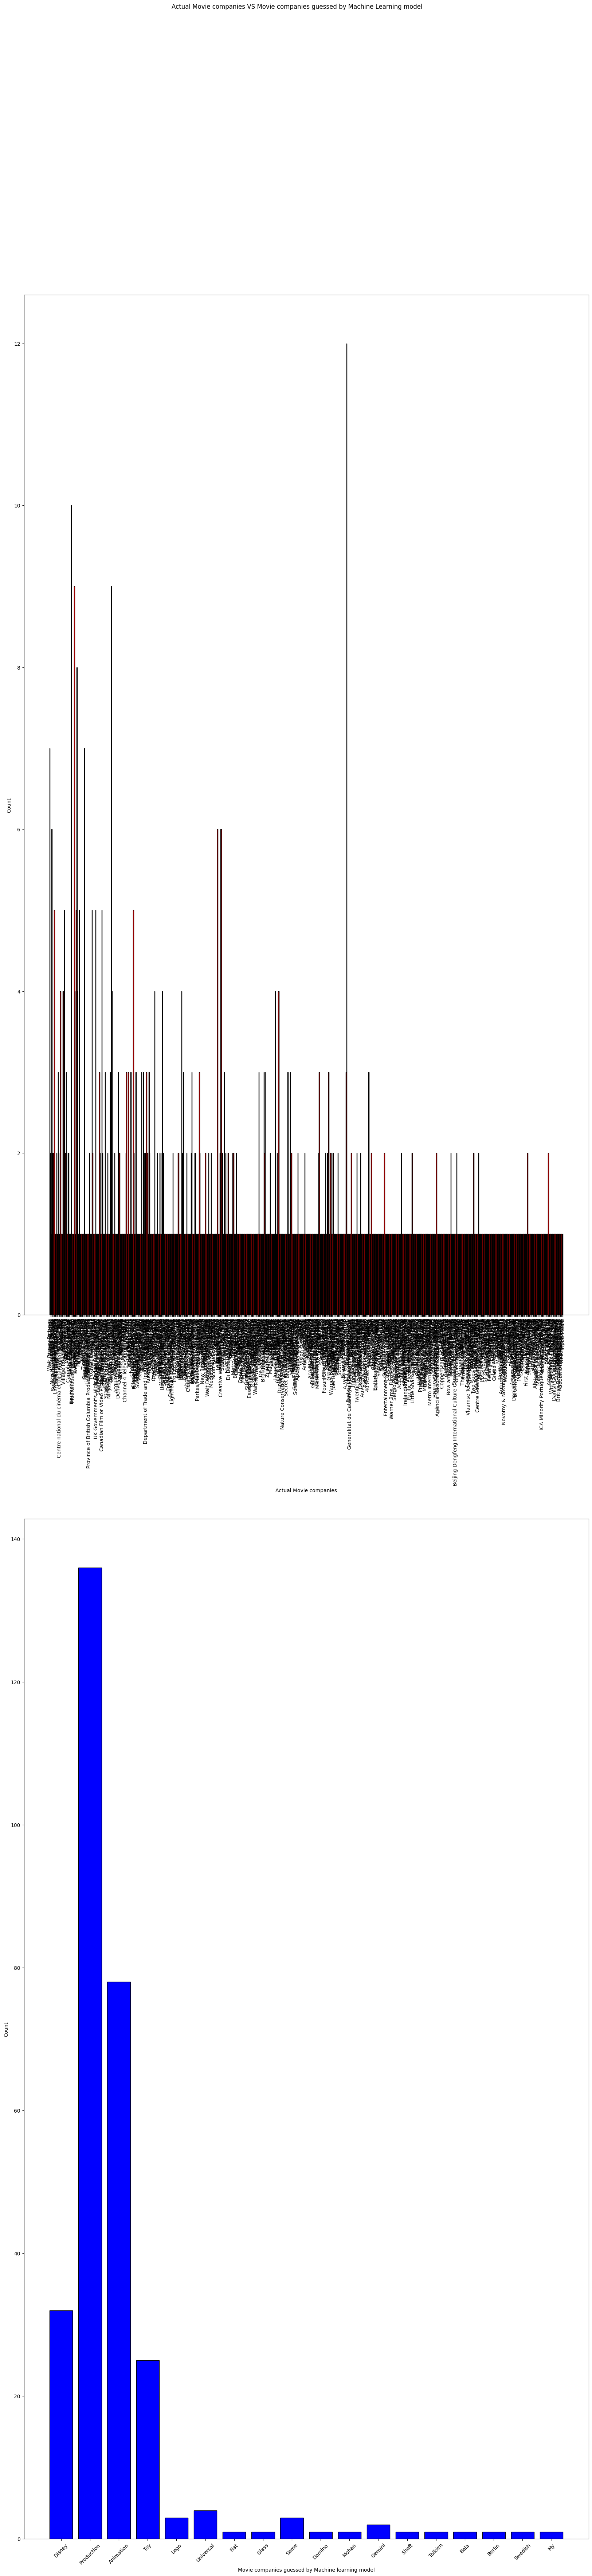

In [102]:
# histogram for company name compared with machine learning model created list.
import matplotlib.pyplot as plt

# Split list to use it for bar plot
original_key = list(count_original_list.keys())
original_value = list(count_original_list.values())

learned_key = list(count_learned_list.keys())
learned_value = list(count_learned_list.values())

# Plot bar chart
fig, ax = plt.subplots(2,1, figsize =(20,80))

ax[0].bar(range(len(count_original_list)), original_value, tick_label=original_key, color='red', edgecolor='black')
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_xlabel('Actual Movie companies')
ax[0].set_ylabel('Count')

ax[1].bar(range(len(count_learned_list)), learned_value, tick_label=learned_key, color='blue', edgecolor='black')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_xlabel('Movie companies guessed by Machine learning model')
ax[1].set_ylabel('Count')


fig.suptitle('Actual Movie companies VS Movie companies guessed by Machine Learning model')
plt.show()

{'Walt Disney Pictures': 7, 'Columbia Pictures': 6, 'Summit Entertainment': 5, ' Arte France Cinéma': 3, 'A24': 4, 'Warner Bros.': 4, ' BRON Studios': 5, ' Tencent Pictures': 3, ' Perfect World Pictures': 10, ' Netflix': 9, 'Paramount Pictures': 4, ' Twentieth Century Fox': 5, ' TSG Entertainment': 8, 'Universal Pictures': 4, ' Universal Pictures': 5, 'Netflix': 7, ' Walt Disney Pictures': 5, ' British Film Commission': 5, 'Metro-Goldwyn-Mayer': 3, ' Canadian Film or Video Production Tax Credit (CPTC)': 5, ' Bona Film Group': 3, ' Voltage Pictures': 3, ' Dentsu': 9, ' Seven Bucks Productions': 4, ' Denver and Delilah Productions': 3, ' Misher Films': 3, ' Ingenious Media': 3, ' Sikelia Productions': 3, 'Annapurna Pictures': 5, ' Vinson Films': 3, 'CBS Films': 3, 'New Line Cinema': 3, 'Amazon Studios': 3, ' Automatik Entertainment': 3, ' Fox Searchlight Pictures': 4, ' Fuji Television Network': 4, ' Blumhouse Productions': 4, 'Lionsgate': 3, 'Fox Searchlight Pictures': 3, ' Columbia Pic

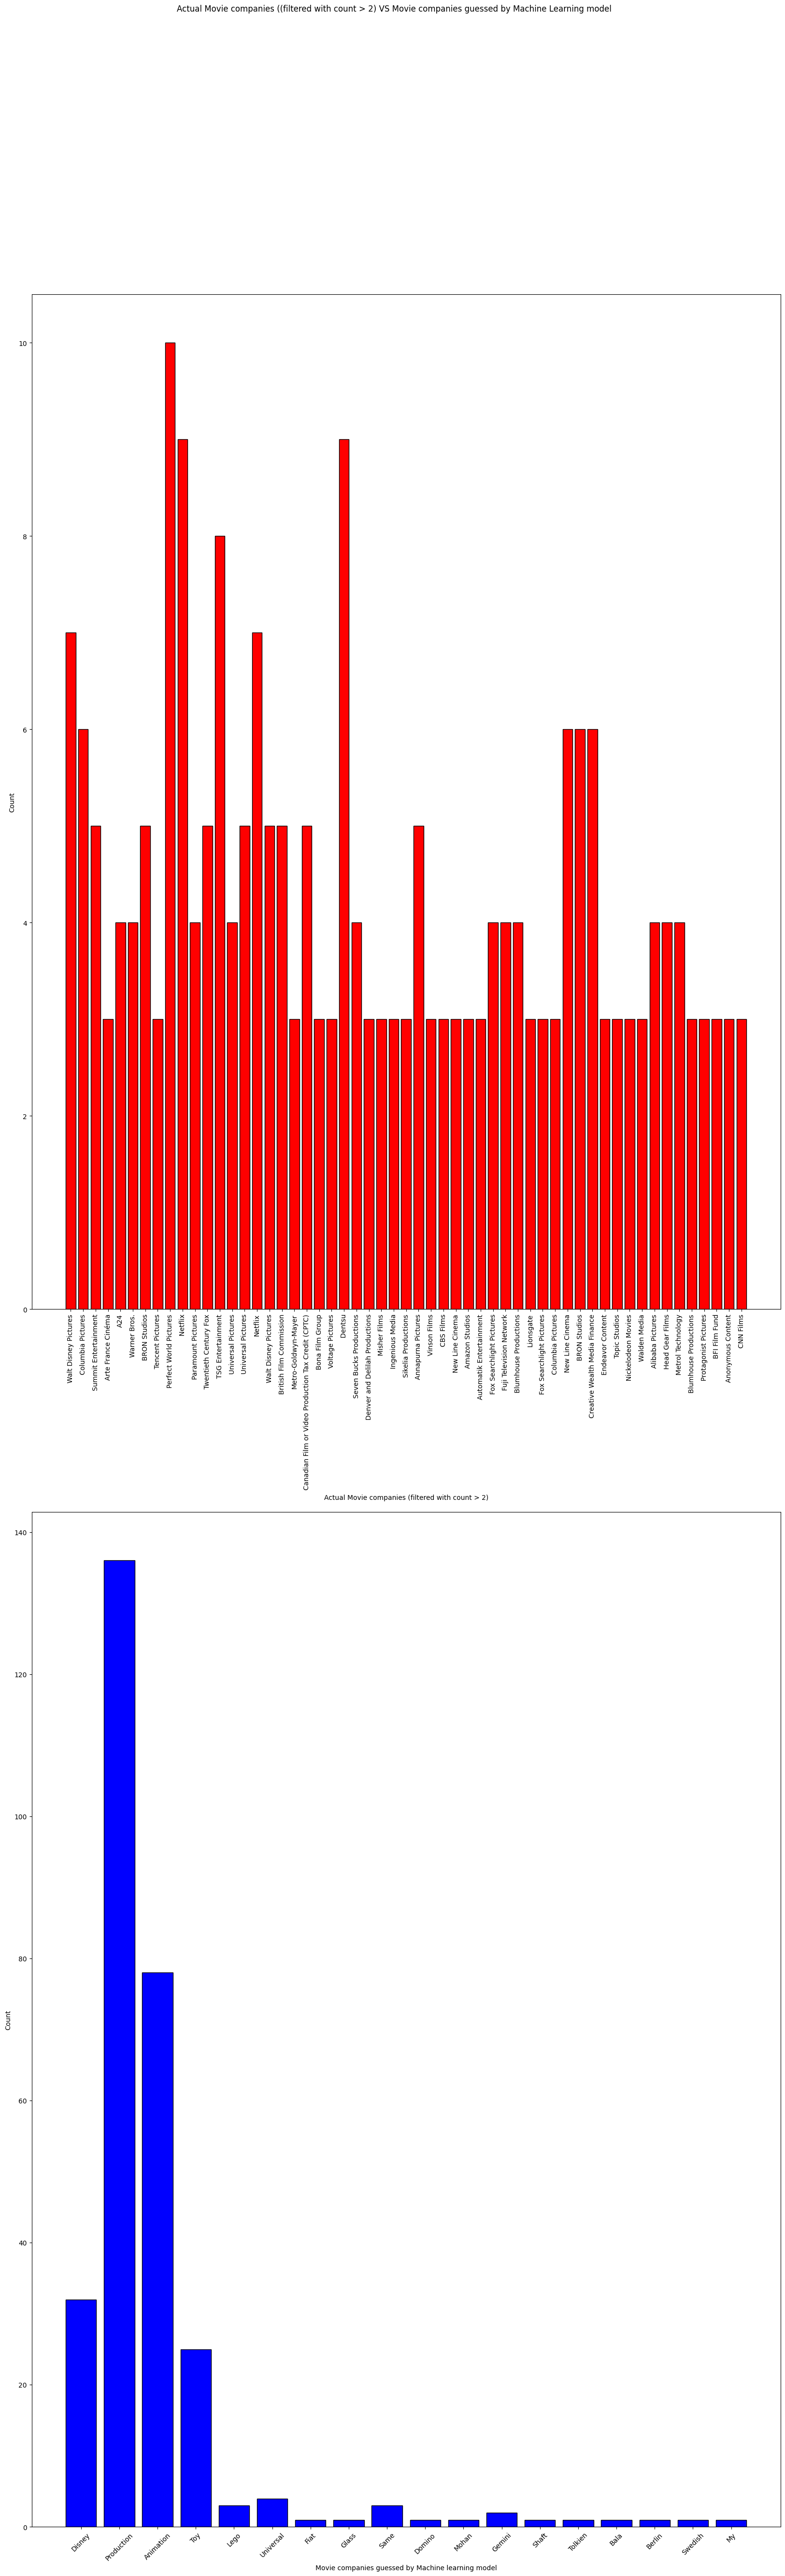

In [103]:
# filter data to delete original company count = 1
filtered_original_list = {k:v for (k,v) in count_original_list.items() if v>2 and k !='' and k !=' '}
print(filtered_original_list)

filtered_key = list(filtered_original_list.keys())
filtered_value = list(filtered_original_list.values())

learned_key = list(count_learned_list.keys())
learned_value = list(count_learned_list.values())

# Plot bar chart with filtered data
fig, ax = plt.subplots(2,1, figsize =(20,60))

ax[0].bar(range(len(filtered_original_list)), filtered_value, tick_label=filtered_key, color='red', edgecolor='black')
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_xlabel('Actual Movie companies (filtered with count > 2)')
ax[0].set_ylabel('Count')

ax[1].bar(range(len(count_learned_list)), learned_value, tick_label=learned_key, color='blue', edgecolor='black')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_xlabel('Movie companies guessed by Machine learning model')
ax[1].set_ylabel('Count')


fig.suptitle('Actual Movie companies ((filtered with count > 2) VS Movie companies guessed by Machine Learning model')
plt.show()



In [104]:
# Write code to see how much machine learning model matches with actual data

match_list = []
count = 0
# Get elements in the same position from 2 lists
for i in range(len(learned_list)):
    element1 = learned_list[i]
    element2 = original_list[i]
    # Check if one string is part of the other string
    if element1 in element2:
        count += 1
        match_list.append(element1)
    else:
        match_list.append("No match found")

print(match_list)

# Get percentage of matching rate and round to 3 decimals
percentage = round((count/len(learned_list)),3)

print(f"Total {count} movie company was matched with machine learning model data and actual data.")
print(f"This machine learning model has {percentage*100}% of accuracy.")

['Disney', 'Production', 'No match found', 'No match found', 'No match found', 'No match found', 'No match found', 'No match found', 'No match found', 'No match found', 'No match found', 'No match found', 'No match found', 'No match found', 'No match found', 'No match found', 'No match found', 'No match found', 'No match found', 'No match found', 'No match found', 'Production', 'No match found', 'No match found', 'No match found', 'No match found', 'Production', 'Production', 'No match found', 'Disney', 'No match found', 'No match found', 'Production', 'No match found', 'No match found', 'Production', 'Production', 'No match found', 'No match found', 'No match found', 'Production', 'Production', 'No match found', 'No match found', 'No match found', 'No match found', 'No match found', 'No match found', 'No match found', 'No match found', 'Production', 'No match found', 'No match found', 'No match found', 'No match found', 'Production', 'No match found', 'Production', 'No match found', '

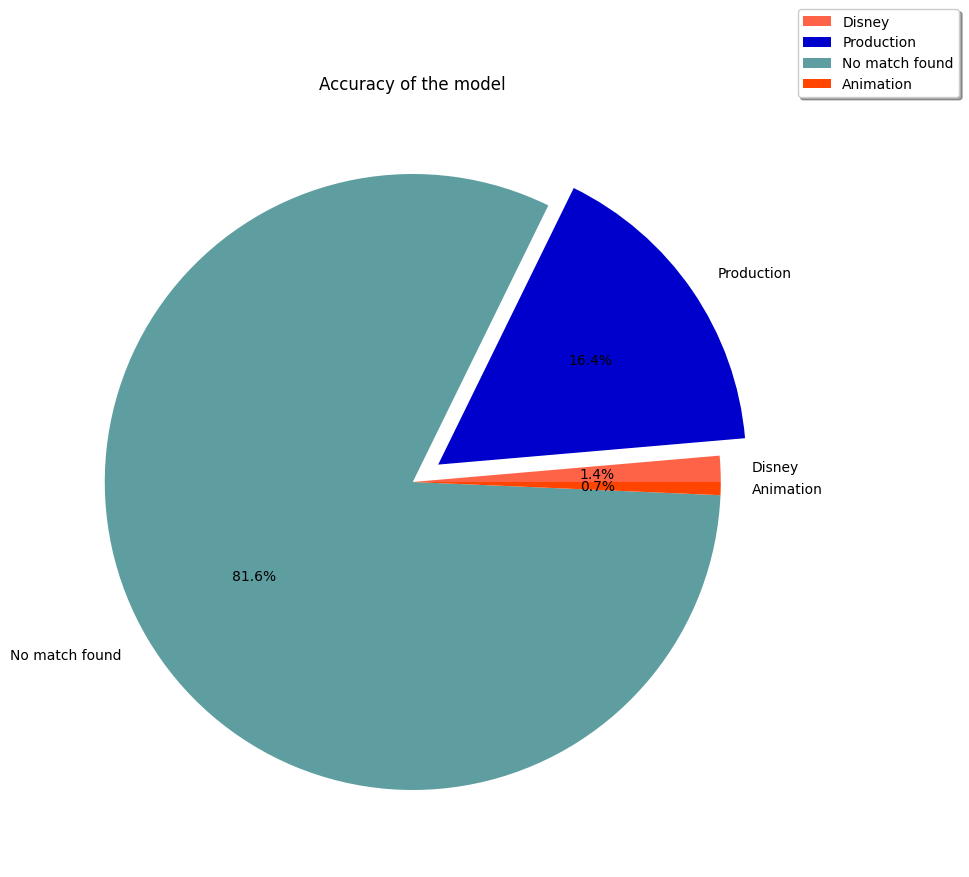

In [105]:
import matplotlib.colors as pltc
from random import sample

# Count values in match list
count_match_list = Counter(match_list)

match_key = list(count_match_list.keys())
match_value = list(count_match_list.values())

# Set the most useful value to explode in the pie chart
explode = (0, 0.1, 0, 0)

# Select random colors 
all_colors = [k for k,v in pltc.cnames.items()]
colors = sample(all_colors, len(count_match_list))

# Plot pie chart
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(match_value, labels=match_key, autopct='%1.1f%%', explode=explode, colors=colors)
ax.set_title("Accuracy of the model")
ax.legend(match_key, loc=(1,1), shadow=True)
plt.show()

```
I actually had to try writing a couple different prompts for this Al model. 
•	My movie’s description is ‘{row[‘description’]}’. This movie’s genre is [MASK].
•	My movie rating is ‘{row[‘score’]} out of 100’. This movie is [MASK] movie.
Neither of these had relevant answers. For example, I remember getting different country names as answers for the first prompt, and ‘Excellent’ or ‘Good’ for most of the answers for the second prompt. With my prompt ‘My movie’s title is ‘{row[‘title’]}’. This movie is made from [MASK] company.’, I was able to get more relevant answers. However, it only had 18.4% accuracy when I checked if the data generated by AI model was included in the original data set. By trying these prompts, I noticed that DistilBERT model is a bit limited, and it is important to write good prompts. 
Overall, it was a great experience using an AI model for the first time. I wonder how accurate AI models can get eventually and what are good ways to write proper prompts. 

```